## Cart Pole Swingup Constrained

In [ ]:
"""
Solution code for the problem "Cart-pole balance".

Autonomous Systems Lab (ASL), Stanford University
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from animations import animate_cartpole

import pdb

# Constants
n = 4  # state dimension
m = 1  # control dimension
mp = 2.0  # pendulum mass
mc = 10.0  # cart mass
L = 1.0  # pendulum length
g = 9.81  # gravitational acceleration
dt = 0.1  # discretization time step
animate = False  # whether or not to animate results


def cartpole(s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """Compute the cart-pole state derivative

    Args:
        s (np.ndarray): The cartpole state: [x, theta, x_dot, theta_dot], shape (n,)
        u (np.ndarray): The cartpole control: [F_x], shape (m,)

    Returns:
        np.ndarray: The state derivative, shape (n,)
    """
    x, θ, dx, dθ = s
    sinθ, cosθ = np.sin(θ), np.cos(θ)
    h = mc + mp * (sinθ**2)
    ds = np.array(
        [
            dx,
            dθ,
            (mp * sinθ * (L * (dθ**2) + g * cosθ) + u[0]) / h,
            -((mc + mp) * g * sinθ + mp * L * (dθ**2) * sinθ * cosθ + u[0] * cosθ)
            / (h * L),
        ]
    )
    return ds


def reference(t: float) -> np.ndarray:
    """Compute the reference state (s_bar) at time t

    Args:
        t (float): Evaluation time

    Returns:
        np.ndarray: Reference state, shape (n,)
    """
    a = 10.0  # Amplitude
    T = 10.0  # Period
    # breakpoint()
    # PART (d) ##################################################
    # INSTRUCTIONS: Compute the reference state for a given time
    # raise NotImplementedError()
    return np.array([a * np.sin(2*np.pi*t/T), np.pi, 2*np.pi*a/T * np.cos(2*np.pi*t/T), 0]).T
    # END PART (d) ##############################################


def ricatti_recursion(
    A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray
) -> np.ndarray:
    """Compute the gain matrix K through Ricatti recursion

    Args:
        A (np.ndarray): Dynamics matrix, shape (n, n)
        B (np.ndarray): Controls matrix, shape (n, m)
        Q (np.ndarray): State cost matrix, shape (n, n)
        R (np.ndarray): Control cost matrix, shape (m, m)

    Returns:
        np.ndarray: Gain matrix K, shape (m, n)
    """
    eps = 1e-4  # Riccati recursion convergence tolerance
    max_iters = 1000  # Riccati recursion maximum number of iterations
    P_prev = np.zeros((n, n))  # initialization
    converged = False
    for i in range(max_iters):
        # PART (b) ##################################################
        # INSTRUCTIONS: Apply the Ricatti equation until convergence
        K = -np.linalg.inv(R + B.T @ P_prev @ B) @ B.T @ P_prev @ A
        P_k = Q + A.T @ P_prev @ (A + B @ K)

        # termination condition
        if np.max(np.abs(P_prev-P_k)) < 1e-4:
            converged = True
            break
        else:
            P_prev = P_k
        # END PART (b) ##############################################
    if not converged:
        raise RuntimeError("Ricatti recursion did not converge!")
    print("K:", K)
    return K


def simulate(
    t: np.ndarray, s_ref: np.ndarray, u_ref: np.ndarray, s0: np.ndarray, K: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Simulate the cartpole

    Args:
        t (np.ndarray): Evaluation times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        u_ref (np.ndarray): Reference control u_bar, shape (m,)
        s0 (np.ndarray): Initial state, shape (n,)
        K (np.ndarray): Feedback gain matrix (Ricatti recursion result), shape (m, n)

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The state history, shape (num_timesteps, n)
            np.ndarray: The control history, shape (num_timesteps, m)
    """

    def cartpole_wrapper(s, t, u):
        """Helper function to get cartpole() into a form preferred by odeint, which expects t as the second arg"""
        return cartpole(s, u)

    # PART (c) ##################################################
    # INSTRUCTIONS: Complete the function to simulate the cartpole system
    # Hint: use the cartpole wrapper above with odeint
    
    # breakpoint()
    
    s = np.zeros((len(t), n))
    s[0,:] = s0

    u = np.zeros((len(t),m)) # [K@s0] #K @ s
    # print("State Variable: ", s_ref[0,:], s0)
    # breakpoint()
    u[0] = K @ (s0 - s_ref[0,:]).T - u_ref
    # breakpoint()
    for i, tk in enumerate(t[:-1]):

        # print(i, u[i,0], s[i,:])
        sol = odeint(cartpole_wrapper, s[i,:], t[0:0+2], (u[i],))
        # breakpoint()
        u[i+1] = K @ (sol[1] - s_ref[i]).T - u_ref
        s[i+1,:] = sol[1]

    # END PART (c) ##############################################
    return s, u


def compute_lti_matrices() -> tuple[np.ndarray, np.ndarray]:
    """Compute the linearized dynamics matrices A and B of the LTI system

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The A (dynamics) matrix, shape (n, n)
            np.ndarray: The B (controls) matrix, shape (n, m)
    """
    # PART (a) ##################################################
    df_ds = np.array(
        [
            [0, 0, 1, 0],
            [0, 0 ,0, 1],
            [0, mp*g/mc, 0, 0],
            [0, (mc+mp)*g/(mc*L), 0, 0]
        ]
    )

    df_du = np.array(
        [
            [0],
            [0],
            [1/mc],
            [1/(mc*L)]
        ]
    )

    # INSTRUCTIONS: Construct the A and B matrices
    A = np.eye(4) + dt * df_ds
    B = dt * df_du
    # END PART (a) ##############################################
    return A, B


def plot_state_and_control_history(
    s: np.ndarray, u: np.ndarray, t: np.ndarray, s_ref: np.ndarray, name: str
) -> None:
    """Helper function for cartpole visualization

    Args:
        s (np.ndarray): State history, shape (num_timesteps, n)
        u (np.ndarray): Control history, shape (num_timesteps, m)
        t (np.ndarray): Times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        name (str): Filename prefix for saving figures
    """
    fig, axes = plt.subplots(1, n + m, dpi=150, figsize=(15, 2))
    plt.subplots_adjust(wspace=0.35)
    labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
    labels_u = (r"$u(t)$",)
    for i in range(n):
        axes[i].plot(t, s[:, i])
        axes[i].plot(t, s_ref[:, i], "--")
        axes[i].set_xlabel(r"$t$")
        axes[i].set_ylabel(labels_s[i])
    for i in range(m):
        axes[n + i].plot(t, u[:, i])
        axes[n + i].set_xlabel(r"$t$")
        axes[n + i].set_ylabel(labels_u[i])
    plt.savefig(f"{name}.png", bbox_inches="tight")
    plt.show()

    if animate:
        fig, ani = animate_cartpole(t, s[:, 0], s[:, 1])
        ani.save(f"{name}.mp4", writer="ffmpeg")
        plt.show()


def main():
    # Part A
    A, B = compute_lti_matrices()

    # Part B
    Q = np.eye(n) * 10  # state cost matrix
    R = np.eye(m)  # control cost matrix
    K = ricatti_recursion(A, B, Q, R)

    # Part C
    t = np.arange(0.0, 30.0, 1 / 10)
    s_ref = np.array([0.0, np.pi, 0.0, 0.0]) * np.ones((t.size, 1))
    u_ref = np.array([0.0])
    s0 = np.array([0.0, 3*np.pi/4, 0.0, 0.0])
    s, u = simulate(t, s_ref, u_ref, s0, K)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance")

    # Part D
    # Note: t, u_ref unchanged from part c
    s_ref = np.array([reference(ti) for ti in t])
    s0 = np.array([0.0, np.pi, 0.0, 0.0])
    s, u = simulate(t, s_ref, u_ref, s0, K)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance_tv")


if __name__ == "__main__":
    main()


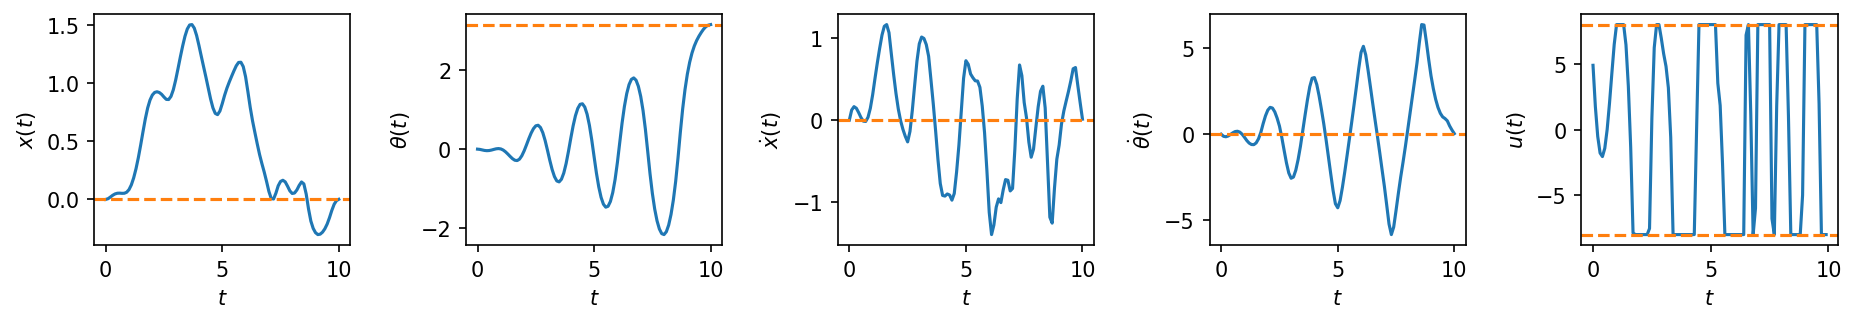

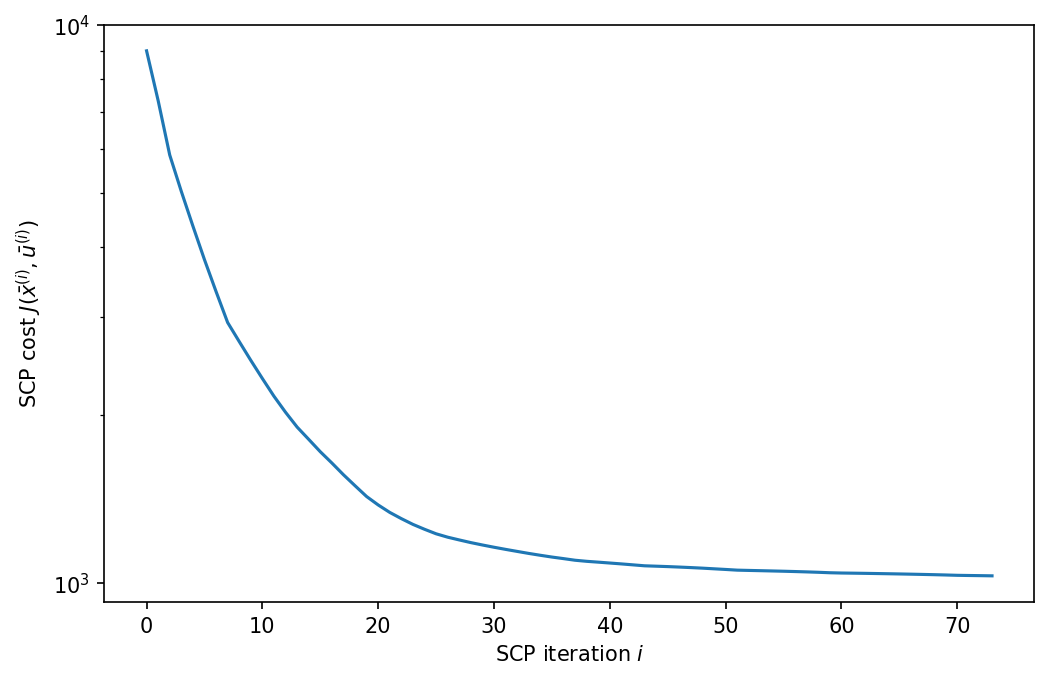

## Cart Pole Balancing

K: [[   2.26379564 -256.34294732    8.42679164  -76.04341843]]


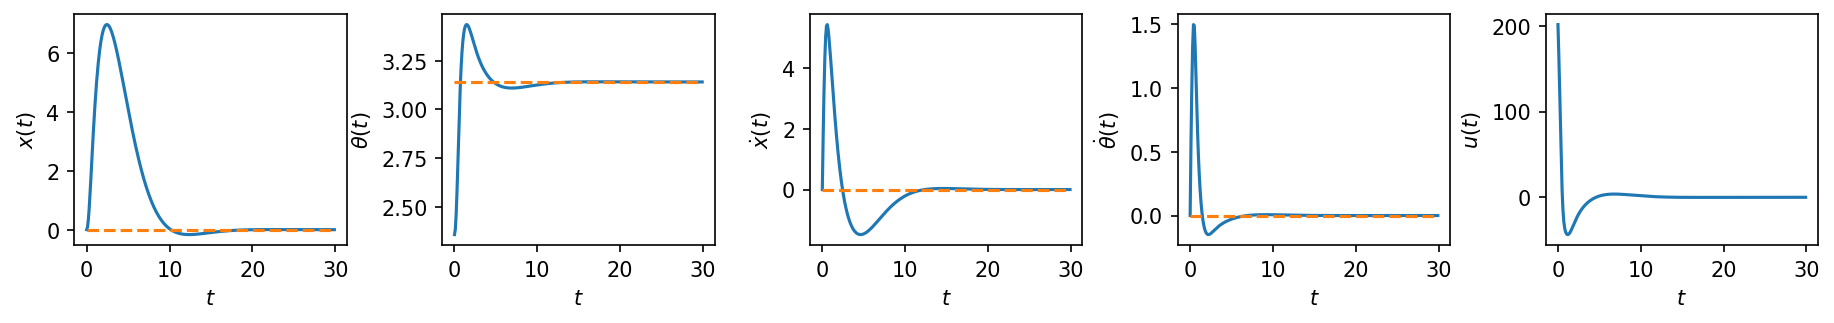

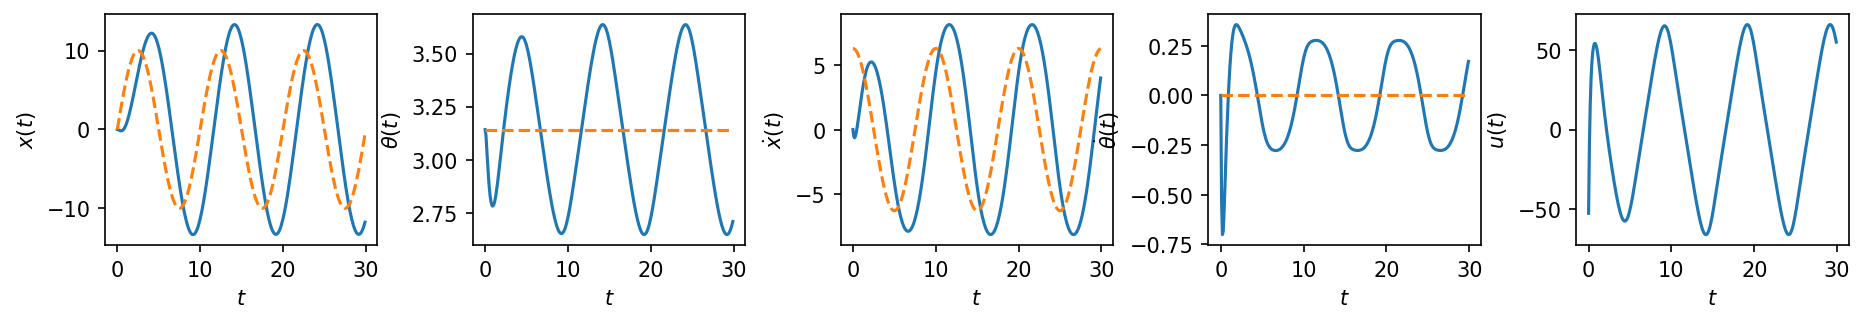

In [1]:
"""
Solution code for the problem "Cart-pole balance".

Autonomous Systems Lab (ASL), Stanford University
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from animations import animate_cartpole

import pdb

# Constants
n = 4  # state dimension
m = 1  # control dimension
mp = 2.0  # pendulum mass
mc = 10.0  # cart mass
L = 1.0  # pendulum length
g = 9.81  # gravitational acceleration
dt = 0.1  # discretization time step
animate = False  # whether or not to animate results


def cartpole(s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """Compute the cart-pole state derivative

    Args:
        s (np.ndarray): The cartpole state: [x, theta, x_dot, theta_dot], shape (n,)
        u (np.ndarray): The cartpole control: [F_x], shape (m,)

    Returns:
        np.ndarray: The state derivative, shape (n,)
    """
    x, θ, dx, dθ = s
    sinθ, cosθ = np.sin(θ), np.cos(θ)
    h = mc + mp * (sinθ**2)
    ds = np.array(
        [
            dx,
            dθ,
            (mp * sinθ * (L * (dθ**2) + g * cosθ) + u[0]) / h,
            -((mc + mp) * g * sinθ + mp * L * (dθ**2) * sinθ * cosθ + u[0] * cosθ)
            / (h * L),
        ]
    )
    return ds


def reference(t: float) -> np.ndarray:
    """Compute the reference state (s_bar) at time t

    Args:
        t (float): Evaluation time

    Returns:
        np.ndarray: Reference state, shape (n,)
    """
    a = 10.0  # Amplitude
    T = 10.0  # Period
    # breakpoint()
    # PART (d) ##################################################
    # INSTRUCTIONS: Compute the reference state for a given time
    # raise NotImplementedError()
    return np.array([a * np.sin(2*np.pi*t/T), np.pi, 2*np.pi*a/T * np.cos(2*np.pi*t/T), 0]).T
    # END PART (d) ##############################################


def ricatti_recursion(
    A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray
) -> np.ndarray:
    """Compute the gain matrix K through Ricatti recursion

    Args:
        A (np.ndarray): Dynamics matrix, shape (n, n)
        B (np.ndarray): Controls matrix, shape (n, m)
        Q (np.ndarray): State cost matrix, shape (n, n)
        R (np.ndarray): Control cost matrix, shape (m, m)

    Returns:
        np.ndarray: Gain matrix K, shape (m, n)
    """
    eps = 1e-4  # Riccati recursion convergence tolerance
    max_iters = 1000  # Riccati recursion maximum number of iterations
    P_prev = np.zeros((n, n))  # initialization
    converged = False
    for i in range(max_iters):
        # PART (b) ##################################################
        # INSTRUCTIONS: Apply the Ricatti equation until convergence
        K = -np.linalg.inv(R + B.T @ P_prev @ B) @ B.T @ P_prev @ A
        P_k = Q + A.T @ P_prev @ (A + B @ K)

        # termination condition
        if np.max(np.abs(P_prev-P_k)) < 1e-4:
            converged = True
            break
        else:
            P_prev = P_k
        # END PART (b) ##############################################
    if not converged:
        raise RuntimeError("Ricatti recursion did not converge!")
    print("K:", K)
    return K


def simulate(
    t: np.ndarray, s_ref: np.ndarray, u_ref: np.ndarray, s0: np.ndarray, K: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Simulate the cartpole

    Args:
        t (np.ndarray): Evaluation times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        u_ref (np.ndarray): Reference control u_bar, shape (m,)
        s0 (np.ndarray): Initial state, shape (n,)
        K (np.ndarray): Feedback gain matrix (Ricatti recursion result), shape (m, n)

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The state history, shape (num_timesteps, n)
            np.ndarray: The control history, shape (num_timesteps, m)
    """

    def cartpole_wrapper(s, t, u):
        """Helper function to get cartpole() into a form preferred by odeint, which expects t as the second arg"""
        return cartpole(s, u)

    # PART (c) ##################################################
    # INSTRUCTIONS: Complete the function to simulate the cartpole system
    # Hint: use the cartpole wrapper above with odeint
    
    # breakpoint()
    
    s = np.zeros((len(t), n))
    s[0,:] = s0

    u = np.zeros((len(t),m)) # [K@s0] #K @ s
    # print("State Variable: ", s_ref[0,:], s0)
    # breakpoint()
    u[0] = K @ (s0 - s_ref[0,:]).T - u_ref
    # breakpoint()
    for i, tk in enumerate(t[:-1]):

        # print(i, u[i,0], s[i,:])
        sol = odeint(cartpole_wrapper, s[i,:], t[0:0+2], (u[i],))
        # breakpoint()
        u[i+1] = K @ (sol[1] - s_ref[i]).T - u_ref
        s[i+1,:] = sol[1]

    # END PART (c) ##############################################
    return s, u


def compute_lti_matrices() -> tuple[np.ndarray, np.ndarray]:
    """Compute the linearized dynamics matrices A and B of the LTI system

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The A (dynamics) matrix, shape (n, n)
            np.ndarray: The B (controls) matrix, shape (n, m)
    """
    # PART (a) ##################################################
    df_ds = np.array(
        [
            [0, 0, 1, 0],
            [0, 0 ,0, 1],
            [0, mp*g/mc, 0, 0],
            [0, (mc+mp)*g/(mc*L), 0, 0]
        ]
    )

    df_du = np.array(
        [
            [0],
            [0],
            [1/mc],
            [1/(mc*L)]
        ]
    )

    # INSTRUCTIONS: Construct the A and B matrices
    A = np.eye(4) + dt * df_ds
    B = dt * df_du
    # END PART (a) ##############################################
    return A, B


def plot_state_and_control_history(
    s: np.ndarray, u: np.ndarray, t: np.ndarray, s_ref: np.ndarray, name: str
) -> None:
    """Helper function for cartpole visualization

    Args:
        s (np.ndarray): State history, shape (num_timesteps, n)
        u (np.ndarray): Control history, shape (num_timesteps, m)
        t (np.ndarray): Times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        name (str): Filename prefix for saving figures
    """
    fig, axes = plt.subplots(1, n + m, dpi=150, figsize=(15, 2))
    plt.subplots_adjust(wspace=0.35)
    labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
    labels_u = (r"$u(t)$",)
    for i in range(n):
        axes[i].plot(t, s[:, i])
        axes[i].plot(t, s_ref[:, i], "--")
        axes[i].set_xlabel(r"$t$")
        axes[i].set_ylabel(labels_s[i])
    for i in range(m):
        axes[n + i].plot(t, u[:, i])
        axes[n + i].set_xlabel(r"$t$")
        axes[n + i].set_ylabel(labels_u[i])
    plt.savefig(f"{name}.png", bbox_inches="tight")
    plt.show()

    if animate:
        fig, ani = animate_cartpole(t, s[:, 0], s[:, 1])
        ani.save(f"{name}.mp4", writer="ffmpeg")
        plt.show()


def main():
    # Part A
    A, B = compute_lti_matrices()

    # Part B
    Q = np.eye(n) * 10  # state cost matrix
    R = np.eye(m)  # control cost matrix
    K = ricatti_recursion(A, B, Q, R)

    # Part C
    t = np.arange(0.0, 30.0, 1 / 10)
    s_ref = np.array([0.0, np.pi, 0.0, 0.0]) * np.ones((t.size, 1))
    u_ref = np.array([0.0])
    s0 = np.array([0.0, 3*np.pi/4, 0.0, 0.0])
    s, u = simulate(t, s_ref, u_ref, s0, K)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance")

    # Part D
    # Note: t, u_ref unchanged from part c
    s_ref = np.array([reference(ti) for ti in t])
    s0 = np.array([0.0, np.pi, 0.0, 0.0])
    s, u = simulate(t, s_ref, u_ref, s0, K)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance_tv")


if __name__ == "__main__":
    main()

K: [[   0.7291397  -231.85419273    4.21967187  -68.24742822]]


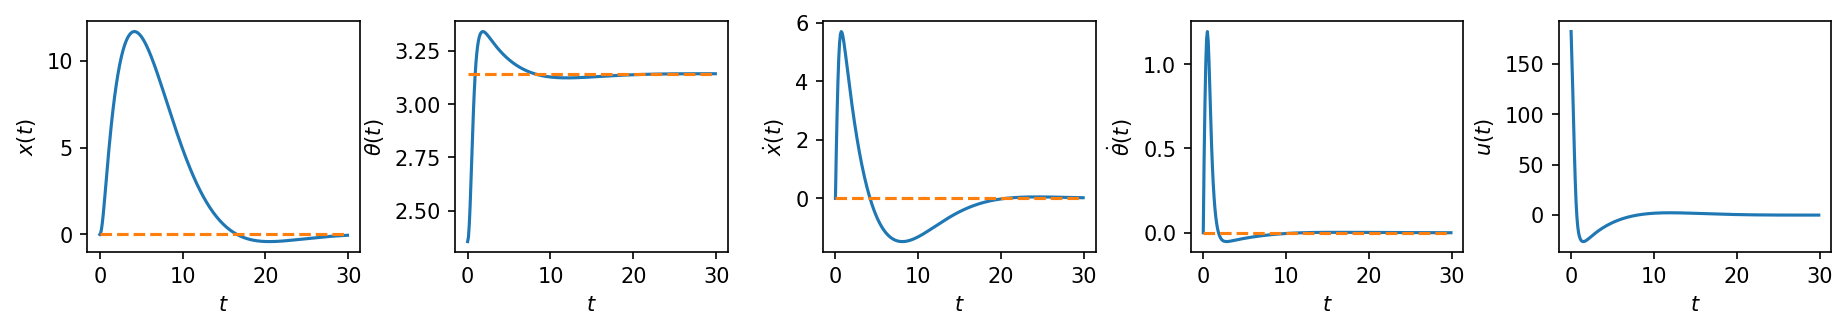

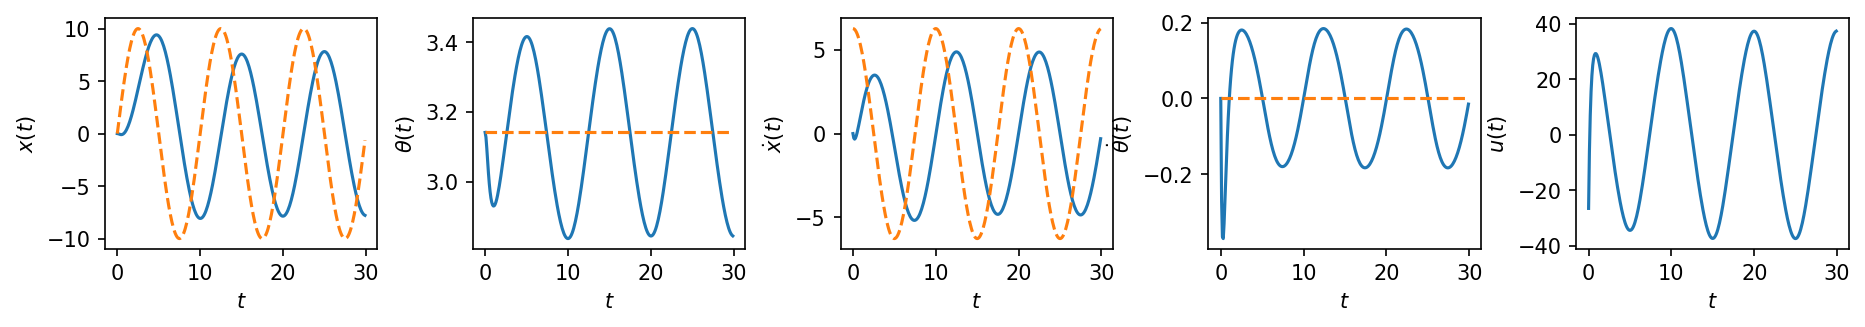

In [2]:
"""
Solution code for the problem "Cart-pole balance".

Autonomous Systems Lab (ASL), Stanford University
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from animations import animate_cartpole

import pdb

# Constants
n = 4  # state dimension
m = 1  # control dimension
mp = 2.0  # pendulum mass
mc = 10.0  # cart mass
L = 1.0  # pendulum length
g = 9.81  # gravitational acceleration
dt = 0.1  # discretization time step
animate = False  # whether or not to animate results


def cartpole(s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """Compute the cart-pole state derivative

    Args:
        s (np.ndarray): The cartpole state: [x, theta, x_dot, theta_dot], shape (n,)
        u (np.ndarray): The cartpole control: [F_x], shape (m,)

    Returns:
        np.ndarray: The state derivative, shape (n,)
    """
    x, θ, dx, dθ = s
    sinθ, cosθ = np.sin(θ), np.cos(θ)
    h = mc + mp * (sinθ**2)
    ds = np.array(
        [
            dx,
            dθ,
            (mp * sinθ * (L * (dθ**2) + g * cosθ) + u[0]) / h,
            -((mc + mp) * g * sinθ + mp * L * (dθ**2) * sinθ * cosθ + u[0] * cosθ)
            / (h * L),
        ]
    )
    return ds


def reference(t: float) -> np.ndarray:
    """Compute the reference state (s_bar) at time t

    Args:
        t (float): Evaluation time

    Returns:
        np.ndarray: Reference state, shape (n,)
    """
    a = 10.0  # Amplitude
    T = 10.0  # Period
    # breakpoint()
    # PART (d) ##################################################
    # INSTRUCTIONS: Compute the reference state for a given time
    # raise NotImplementedError()
    return np.array([a * np.sin(2*np.pi*t/T), np.pi, 2*np.pi*a/T * np.cos(2*np.pi*t/T), 0]).T
    # END PART (d) ##############################################


def ricatti_recursion(
    A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray
) -> np.ndarray:
    """Compute the gain matrix K through Ricatti recursion

    Args:
        A (np.ndarray): Dynamics matrix, shape (n, n)
        B (np.ndarray): Controls matrix, shape (n, m)
        Q (np.ndarray): State cost matrix, shape (n, n)
        R (np.ndarray): Control cost matrix, shape (m, m)

    Returns:
        np.ndarray: Gain matrix K, shape (m, n)
    """
    eps = 1e-4  # Riccati recursion convergence tolerance
    max_iters = 1000  # Riccati recursion maximum number of iterations
    P_prev = np.zeros((n, n))  # initialization
    converged = False
    for i in range(max_iters):
        # PART (b) ##################################################
        # INSTRUCTIONS: Apply the Ricatti equation until convergence
        K = -np.linalg.inv(R + B.T @ P_prev @ B) @ B.T @ P_prev @ A
        P_k = Q + A.T @ P_prev @ (A + B @ K)

        # termination condition
        if np.max(np.abs(P_prev-P_k)) < 1e-4:
            converged = True
            break
        else:
            P_prev = P_k
        # END PART (b) ##############################################
    if not converged:
        raise RuntimeError("Ricatti recursion did not converge!")
    print("K:", K)
    return K


def simulate(
    t: np.ndarray, s_ref: np.ndarray, u_ref: np.ndarray, s0: np.ndarray, K: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Simulate the cartpole

    Args:
        t (np.ndarray): Evaluation times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        u_ref (np.ndarray): Reference control u_bar, shape (m,)
        s0 (np.ndarray): Initial state, shape (n,)
        K (np.ndarray): Feedback gain matrix (Ricatti recursion result), shape (m, n)

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The state history, shape (num_timesteps, n)
            np.ndarray: The control history, shape (num_timesteps, m)
    """

    def cartpole_wrapper(s, t, u):
        """Helper function to get cartpole() into a form preferred by odeint, which expects t as the second arg"""
        return cartpole(s, u)

    # PART (c) ##################################################
    # INSTRUCTIONS: Complete the function to simulate the cartpole system
    # Hint: use the cartpole wrapper above with odeint
    
    # breakpoint()
    
    s = np.zeros((len(t), n))
    s[0,:] = s0

    u = np.zeros((len(t),m)) # [K@s0] #K @ s
    # print("State Variable: ", s_ref[0,:], s0)
    # breakpoint()
    u[0] = K @ (s0 - s_ref[0,:]).T - u_ref
    # breakpoint()
    for i, tk in enumerate(t[:-1]):

        # print(i, u[i,0], s[i,:])
        sol = odeint(cartpole_wrapper, s[i,:], t[0:0+2], (u[i],))
        # breakpoint()
        u[i+1] = K @ (sol[1] - s_ref[i]).T - u_ref
        s[i+1,:] = sol[1]

    # END PART (c) ##############################################
    return s, u


def compute_lti_matrices() -> tuple[np.ndarray, np.ndarray]:
    """Compute the linearized dynamics matrices A and B of the LTI system

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The A (dynamics) matrix, shape (n, n)
            np.ndarray: The B (controls) matrix, shape (n, m)
    """
    # PART (a) ##################################################
    df_ds = np.array(
        [
            [0, 0, 1, 0],
            [0, 0 ,0, 1],
            [0, mp*g/mc, 0, 0],
            [0, (mc+mp)*g/(mc*L), 0, 0]
        ]
    )

    df_du = np.array(
        [
            [0],
            [0],
            [1/mc],
            [1/(mc*L)]
        ]
    )

    # INSTRUCTIONS: Construct the A and B matrices
    A = np.eye(4) + dt * df_ds
    B = dt * df_du
    # END PART (a) ##############################################
    return A, B


def plot_state_and_control_history(
    s: np.ndarray, u: np.ndarray, t: np.ndarray, s_ref: np.ndarray, name: str
) -> None:
    """Helper function for cartpole visualization

    Args:
        s (np.ndarray): State history, shape (num_timesteps, n)
        u (np.ndarray): Control history, shape (num_timesteps, m)
        t (np.ndarray): Times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        name (str): Filename prefix for saving figures
    """
    fig, axes = plt.subplots(1, n + m, dpi=150, figsize=(15, 2))
    plt.subplots_adjust(wspace=0.35)
    labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
    labels_u = (r"$u(t)$",)
    for i in range(n):
        axes[i].plot(t, s[:, i])
        axes[i].plot(t, s_ref[:, i], "--")
        axes[i].set_xlabel(r"$t$")
        axes[i].set_ylabel(labels_s[i])
    for i in range(m):
        axes[n + i].plot(t, u[:, i])
        axes[n + i].set_xlabel(r"$t$")
        axes[n + i].set_ylabel(labels_u[i])
    plt.savefig(f"{name}.png", bbox_inches="tight")
    plt.show()

    if animate:
        fig, ani = animate_cartpole(t, s[:, 0], s[:, 1])
        ani.save(f"{name}.mp4", writer="ffmpeg")
        plt.show()


def main():
    # Part A
    A, B = compute_lti_matrices()

    # Part B
    Q = np.eye(n) * 1  # state cost matrix
    R = np.eye(m)  # control cost matrix
    K = ricatti_recursion(A, B, Q, R)

    # Part C
    t = np.arange(0.0, 30.0, 1 / 10)
    s_ref = np.array([0.0, np.pi, 0.0, 0.0]) * np.ones((t.size, 1))
    u_ref = np.array([0.0])
    s0 = np.array([0.0, 3*np.pi/4, 0.0, 0.0])
    s, u = simulate(t, s_ref, u_ref, s0, K)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance")

    # Part D
    # Note: t, u_ref unchanged from part c
    s_ref = np.array([reference(ti) for ti in t])
    s0 = np.array([0.0, np.pi, 0.0, 0.0])
    s, u = simulate(t, s_ref, u_ref, s0, K)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance_tv")


if __name__ == "__main__":
    main()

# Cart Pole Balance

In [ ]:
"""
Starter code for the problem "Cart-pole swing-up".

Autonomous Systems Lab (ASL), Stanford University
"""

import time

from animations import animate_cartpole

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import numpy as np

from scipy.integrate import odeint


def linearize(f, s, u):
    """Linearize the function `f(s, u)` around `(s, u)`.

    Arguments
    ---------
    f : callable
        A nonlinear function with call signature `f(s, u)`.
    s : numpy.ndarray
        The state (1-D).
    u : numpy.ndarray
        The control input (1-D).

    Returns
    -------
    A : numpy.ndarray
        The Jacobian of `f` at `(s, u)`, with respect to `s`.
    B : numpy.ndarray
        The Jacobian of `f` at `(s, u)`, with respect to `u`.
    """
    # WRITE YOUR CODE BELOW ###################################################
    # INSTRUCTIONS: Use JAX to compute `A` and `B` in one line.
    # raise NotImplementedError()
    A, B = jax.jacrev(f, argnums=(0, 1))(s, u)
    ###########################################################################
    return A, B


def ilqr(f, s0, s_goal, N, Q, R, QN, eps=1e-3, max_iters=1000):
    """Compute the iLQR set-point tracking solution.

    Arguments
    ---------
    f : callable
        A function describing the discrete-time dynamics, such that
        `s[k+1] = f(s[k], u[k])`.
    s0 : numpy.ndarray
        The initial state (1-D).
    s_goal : numpy.ndarray
        The goal state (1-D).
    N : int
        The time horizon of the LQR cost function.
    Q : numpy.ndarray
        The state cost matrix (2-D).
    R : numpy.ndarray
        The control cost matrix (2-D).
    QN : numpy.ndarray
        The terminal state cost matrix (2-D).
    eps : float, optional
        Termination threshold for iLQR.
    max_iters : int, optional
        Maximum number of iLQR iterations.

    Returns
    -------
    s_bar : numpy.ndarray
        A 2-D array where `s_bar[k]` is the nominal state at time step `k`,
        for `k = 0, 1, ..., N-1`
    u_bar : numpy.ndarray
        A 2-D array where `u_bar[k]` is the nominal control at time step `k`,
        for `k = 0, 1, ..., N-1`
    Y : numpy.ndarray
        A 3-D array where `Y[k]` is the matrix gain term of the iLQR control
        law at time step `k`, for `k = 0, 1, ..., N-1`
    y : numpy.ndarray
        A 2-D array where `y[k]` is the offset term of the iLQR control law
        at time step `k`, for `k = 0, 1, ..., N-1`
    """
    if max_iters <= 1:
        raise ValueError("Argument `max_iters` must be at least 1.")
    n = Q.shape[0]  # state dimension
    m = R.shape[0]  # control dimension

    # Initialize gains `Y` and offsets `y` for the policy
    Y = np.zeros((N, m, n))
    y = np.zeros((N, m))
 
    def rollout(x0, u_trj):
        x_trj = np.zeros((u_trj.shape[0] + 1, x0.shape[0]))
        # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
        x_trj[0] = x0
        for i, u in enumerate(u_trj):
            x_trj[i+1] = fd(x_trj[i], u)
        return x_trj

    # Initialize the nominal trajectory `(s_bar, u_bar`), and the
    # deviations `(ds, du)`
    u_bar = np.random.rand(N, m)
    # s_bar[0] = s0
    s_bar = rollout(s0, u_bar)
    for k in range(N):
        s_bar[k + 1] = f(s_bar[k], u_bar[k])
    ds = np.zeros((N + 1, n))
    du = np.zeros((N, m))

    # Define Helper Function
    def forward_pass(x_trj, u_trj, k_trj, K_trj):
            x_trj_new = np.zeros(x_trj.shape)
            x_trj_new[0, :] = x_trj[0, :]
            u_trj_new = np.zeros(u_trj.shape)
            # TODO: Implement the forward pass here
            for n in range(u_trj.shape[0]):
                # Note, converting from deviation variable to actual value variable
                u_trj_new[n,:] = u_trj[n,:] + k_trj[n,:] + K_trj[n,:] @ (x_trj_new[n,:]-x_trj[n,:])# Apply feedback law
                x_trj_new[n+1,:] = fd(x_trj_new[n,:], u_trj_new[n,:]) # Apply dynamics
            return x_trj_new, u_trj_new
    
    @jax.jit
    def cost_stage(x, u):
        return 1/2 * ((x - s_goal).T @ Q @ (x-s_goal) + u.T @ R @ u)

    @jax.jit
    def stage(x, u):
        l = cost_stage
        l_x = jax.jacrev(l, argnums=0)
        l_u = jax.jacrev(l, argnums=1)
        l_xx = jax.jacrev(l_x, argnums=0)
        l_ux = jax.jacrev(l_u, argnums=0)
        l_uu = jax.jacrev(l_u, argnums=1)

        # f = fd
        f_x = jax.jacrev(fd, argnums=0)
        f_u = jax.jacrev(fd, argnums=1)


        return l_x(x, u), l_u(x, u), l_xx(x, u), l_ux(x, u), l_uu(x, u), f_x(x, u), f_u(x, u)

    @jax.jit
    def cost_final(x):
        return 1/2 * (x - s_goal).T @ QN @ (x-s_goal)

    @jax.jit
    def final(x):
        l_final = cost_final
        l_final_x = jax.jacrev(l_final, argnums=0)
        l_final_xx = jax.jacrev(l_final_x, argnums=0)
        
        return  l_final_x(x), l_final_xx(x)

    @jax.jit
    def cost_trj(x_trj, u_trj):
        total = 0.0
        total = (
            cost_final(x_trj[-1])+
            jnp.sum(jnp.array([cost_stage(x, u) for x, u in zip(x_trj[:-1], u_trj)]))
        )

        return total
    
    @jax.jit
    def gains(Q_uu, Q_u, Q_ux):
        Q_uu_inv = jnp.linalg.inv(Q_uu)
        # TODO: Implement the feedforward gain k and feedback gain K.
        k = - Q_uu_inv @ Q_u.T  #np.zeros(Q_u.shape)
        K = - Q_uu_inv @ Q_ux #np.zeros(Q_ux.shape)
        return k, K
    
    @jax.jit
    def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
        # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
        V_x = Q_x + K.T @ Q_u + k.T @ Q_ux + K.T @ Q_uu @ k #np.zeros(Q_x.shape)
        # print(Q_xx.shape, Q_ux.T.shape, K.shape, K.T.shape, Q_ux.shape, K.shape)  #np.zeros(Q_xx.shape)
        V_xx = Q_xx + 2 * Q_ux.T @ K + K.T @ Q_uu @ K  #np.zeros(Q_xx.shape) 
        
        return V_x, V_xx
    
    @jax.jit
    def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
        # TODO: Define the Q-terms here
        Q_x = l_x + V_x.T @ f_x #np.zeros(l_x.shape)
        Q_u = l_u + V_x.T @ f_u #np.zeros(l_u.shape)
        Q_xx = l_xx + f_x.T @ V_xx @ f_x #np.zeros(l_xx.shape)
        Q_ux = l_ux + f_u.T @ V_xx @ f_x #np.zeros(l_ux.shape)
        Q_uu = l_uu + f_u.T @ V_xx @ f_u #np.zeros(l_uu.shape)
        return Q_x, Q_u, Q_xx, Q_ux, Q_uu
    
    def backward_pass(x_trj, u_trj, regu=0):
        k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
        K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
        # expected_cost_redu = 0
        # TODO: Set terminal boundary condition here (V_x, V_xx)
        V_x, V_xx = final(x_trj[-1])

        for n in range(u_trj.shape[0] - 1, -1, -1):
            # TODO: First compute derivatives, then the Q-terms
            l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = stage(x_trj[n], u_trj[n])

            Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)

            # We add regularization to ensure that Q_uu is invertible and nicely conditioned
            Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0]) * regu
            k, K = gains(Q_uu_regu, Q_u, Q_ux)
            k_trj[n, :] = k
            K_trj[n, :, :] = K
            V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
            # expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
        return k_trj, K_trj#, expected_cost_redu


    # iLQR loop
    converged = False
    cost = np.inf
    for _ in range(max_iters):
        # Linearize the dynamics at each step `k` of `(s_bar, u_bar)`
        A, B = jax.vmap(linearize, in_axes=(None, 0, 0))(f, s_bar[:-1], u_bar)
        A, B = np.array(A), np.array(B)

        # PART (c) ############################################################
        # INSTRUCTIONS: Update `Y`, `y`, `ds`, `du`, `s_bar`, and `u_bar`.
        # raise NotImplementedError()

        y, Y = backward_pass(s_bar, u_bar, regu=0)

        s_bar_new, u_bar_new = forward_pass(s_bar, u_bar, y, Y)

        print(cost_trj(s_bar_new, u_bar_new))

        du = u_bar_new - u_bar
        s_bar = s_bar_new
        u_bar = u_bar_new

        #######################################################################

        if np.max(np.abs(du)) < eps:
            converged = True
            print('Converged')
            break
        # print('one more')
    if not converged:
        print("iLQR did not converge!")
    return s_bar, u_bar, Y, y


def cartpole(s, u):
    """Compute the cart-pole state derivative."""
    mp = 2.0  # pendulum mass
    mc = 10.0  # cart mass
    L = 1.0  # pendulum length
    g = 9.81  # gravitational acceleration

    x, θ, dx, dθ = s
    sinθ, cosθ = jnp.sin(θ), jnp.cos(θ)
    h = mc + mp * (sinθ**2)
    ds = jnp.array(
        [
            dx,
            dθ,
            (mp * sinθ * (L * (dθ**2) + g * cosθ) + u[0]) / h,
            -((mc + mp) * g * sinθ + mp * L * (dθ**2) * sinθ * cosθ + u[0] * cosθ)
            / (h * L),
        ]
    )
    return ds


# Define constants
n = 4  # state dimension
m = 1  # control dimension
Q = np.diag(np.array([10.0, 10.0, 2.0, 2.0]))  # state cost matrix
R = 1e-2 * np.eye(m)  # control cost matrix
QN = 1e2 * np.eye(n)  # terminal state cost matrix
s0 = np.array([0.0, 0.0, 0.0, 0.0])  # initial state
s_goal = np.array([0.0, np.pi, 0.0, 0.0])  # goal state
T = 10.0  # simulation time
dt = 0.1  # sampling time
animate = False  # flag for animation
closed_loop = False  # flag for closed-loop control

# Initialize continuous-time and discretized dynamics
f = jax.jit(cartpole)
fd = jax.jit(lambda s, u, dt=dt: s + dt * f(s, u))

# Compute the iLQR solution with the discretized dynamics
print("Computing iLQR solution ... ", end="", flush=True)
start = time.time()
t = np.arange(0.0, T, dt)
N = t.size - 1
s_bar, u_bar, Y, y = ilqr(fd, s0, s_goal, N, Q, R, QN)
print("done! ({:.2f} s)".format(time.time() - start), flush=True)

# Plot iLQR solution
# fig, axes = plt.subplots(1, n + m, dpi=150, figsize=(15, 2))
# plt.subplots_adjust(wspace=0.45)
# labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
# labels_u = (r"$u(t)$",)
# for i in range(n):
#     axes[i].plot(t, s_bar[:, i])
#     axes[i].set_xlabel(r"$t$")
#     axes[i].set_ylabel(labels_s[i])
# for i in range(m):
#     axes[n + i].plot(t[:-1], u_bar[:, i])
#     axes[n + i].set_xlabel(r"$t$")
#     axes[n + i].set_ylabel(labels_u[i])

# axes[1].axhline(np.pi, linestyle="--", color="tab:orange")

# Simulate on the true continuous-time system
print("Simulating ... ", end="", flush=True)
start = time.time()
s = np.zeros((N + 1, n))
u = np.zeros((N, m))
s[0] = s0
for k in range(N):
    # PART (d) ################################################################
    # INSTRUCTIONS: Compute either the closed-loop or open-loop value of
    # `u[k]`, depending on the Boolean flag `closed_loop`.
    if closed_loop:
        u[k] = 0.0
        raise NotImplementedError()
    else:  # do open-loop control
        u[k] = u_bar[k]
        # raise NotImplementedError()
    ###########################################################################
    s[k + 1] = odeint(lambda s, t: f(s, u[k]), s[k], t[k : k + 2])[1]
print("done! ({:.2f} s)".format(time.time() - start), flush=True)

# Plot
fig, axes = plt.subplots(1, n + m, dpi=150, figsize=(15, 2))
plt.subplots_adjust(wspace=0.45)
labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
labels_u = (r"$u(t)$",)
for i in range(n):
    axes[i].plot(t, s[:, i])
    axes[i].set_xlabel(r"$t$")
    axes[i].set_ylabel(labels_s[i])
for i in range(m):
    axes[n + i].plot(t[:-1], u[:, i])
    axes[n + i].set_xlabel(r"$t$")
    axes[n + i].set_ylabel(labels_u[i])
if closed_loop:
    plt.savefig("cartpole_swingup_cl.png", bbox_inches="tight")
else:
    plt.savefig("cartpole_swingup_ol.png", bbox_inches="tight")
plt.show()

if animate:
    fig, ani = animate_cartpole(t, s[:, 0], s[:, 1])
    ani.save("cartpole_swingup.mp4", writer="ffmpeg")
    plt.show()